# MSDS 7331 - Mini-Project: SVM&LR Classification
## Team: Dineen Parker, Dale Legband, Ryan Shuhart
collaboration site: https://github.com/rlshuhart/MSDS7331_Mini-Lab

### Log to capture iterations of findings and ideas for feature selection and analysis

1. First attempt of logistic model revealed need to one-hot encode categorical variables
2. After numerically encoding categorical variables, the logistic model more or less predicted all to not default.
3. Changeing penalty on logistic model from l2 to l1 improved the model by about 3 percentage points.
4. Changing class_weight='balanced' negatively impacted model
5. Changing C to 100 had no impact
6. Changing C to .0001 had small negative impact
7. Reviewed logistic coefficients on scaled data and it appears the most recent pay status (PAY_0_Sept), the most recent two bill amounts ('BILL_AMT1_Sept', 'BILL_AMT2_Aug'), the most recent two payment amounts are the highest predictors ('PAY_AMT1_Sept', 'PAY_AMT2_Aug').
8. Full SVM Model was stopped after not completing after 2 hours. SGD will be pursued instead.

## SVM and Logistic Regression Modeling  
* [50 points] Create a logistic regression model and a support vector machine model for the classiﬁcation task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is ﬁne to use. 
* [10 points] Discuss the advantages of each model for each classiﬁcation task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efﬁciency? Explain in detail.  
* [30 points] Use the weights from logistic regression to interpret the importance of different features for each classiﬁcation task. Explain your interpretation in detail. Why do you think some variables are more important? 
* [10 points] Look at the chosen support vectors for the classiﬁcation task. Do these provide any insight into the data? Explain

In [1]:
### Modules Used ###

# Data manipulation: pandas and numpy
import pandas as pd
import numpy as np

# Visualization: seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import time

# Read in preprocessed data from previous assignment

In [2]:
# Random but useful fact: if the first record in a csv file is 
# "ID" than Excel will interpret it as a SYLK file
# https://annalear.ca/2010/06/10/why-excel-thinks-your-csv-is-a-sylk/

#data_url = "https://raw.githubusercontent.com/rlshuhart/MSDS7331_Project_1/master/cc_data/cc_data_processed.csv"
data_url = "../MSDS7331_Project_1/cc_data/cc_data_processed.csv"

cc_data = pd.read_csv(data_url, index_col='ID')

In [3]:
print(cc_data.info())
print()
print(cc_data.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 27 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null object
EDUCATION                     30000 non-null object
MARRIAGE                      30000 non-null object
AGE                           30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept        

# Additional Preprocessing of data

### One hot encoding of categorical variables

In [4]:
# makeing copy of data to retain original input for now. 
# Have to add .copy() or any change will reflect in the original too.
cc_data_processed = cc_data.copy()

cats = ['SEX', 'EDUCATION', 'MARRIAGE','AGE_range', 'LIMIT_BAL_range']

# SEX convert to isMale
cc_data_processed['isMale'] = cc_data['SEX']=='Male'

# Two options for Education: 
# If treating ordinal then keep single columnn but label in numerical order
# if nominal then create dummy variables.
# Trying ordinal first with 'Others' as the highest. Previous exploration
# showed this group have better rates of default which continued the trend
# of more education means less likely to default:
cc_data_processed['EDUCATION'] = cc_data['EDUCATION'].apply({'High School':0,
                                                             'University':1,
                                                             'Graduate School':2, 
                                                             'Others':3}.get)

# Marriage is nominal category therefore converting to dummies

cc_data_processed = pd.concat((cc_data_processed, 
                               pd.get_dummies(cc_data['MARRIAGE'], prefix='Marriage')), 
                               axis=1)

# Age range is ordinal category:
cc_data_processed['AGE_range'] = cc_data['AGE_range'].apply({'21-30':0,
                                                             '31-40':1,
                                                             '41-50':2, 
                                                             '51-60':3,
                                                             '61-70':4,
                                                             '71-80+':5}.get)
# Limit_Bal_Range is ordingal
cc_data_processed['LIMIT_BAL_range'] = cc_data['LIMIT_BAL_range'].apply({'0-250k':0,
                                                                         '>250k-500k':1,
                                                                         '>500k-750k':2,
                                                                         '>750k':3}.get)

# Drop unused features:
# 'Default_Yes_No' - Used for visualization labeling only and same as 'default payment next month'
# 'AGE' - Using Age_range instead, may bring back
cc_data_processed.drop(['Default_Yes_No','AGE', 'SEX','MARRIAGE', 'LIMIT_BAL'], axis=1, inplace=True)

print(cc_data_processed.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 26 columns):
EDUCATION                     30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept                 30000 non-null int64
PAY_AMT2_Aug                  30000 non-null int64
PAY_AMT3_July                 30000 non-null int64
PAY_AMT4_June                 30000 non-null int64
PAY_AMT5_May            

#### Convert data to numpy arrays for training

In [5]:
cc_data_target = cc_data_processed['default payment next month'].values
cc_data_Xs = cc_data_processed.drop('default payment next month', axis='columns').values

# Column names for labeling
cc_data_Xs_names = cc_data_processed.drop('default payment next month', axis='columns').columns

# Prediction Models

In [6]:
# Scikit Modules
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn import grid_search

In [7]:
# Create Cross Validation object with an 80/20 split
num_cv_iterations = 10
num_instances = len(cc_data_target)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)

In [8]:
# Sample Default Rate
sample_d_rt = (1 - cc_data_target.sum() / len(cc_data_target))*100
print("The sample default rate is: %.1f%%"  % sample_d_rt)

# The sample default rate is the same as predicting all zeros (or no defaults)
all_zeros = np.zeros(len(cc_data_target))
all_zero_score = mt.accuracy_score(cc_data_target,all_zeros)*100
print("The models should have an accuracy better than predicting all non-defaults of %.1f%%"  % all_zero_score)

The sample default rate is: 77.9%
The models should have an accuracy better than predicting all non-defaults of 77.9%


## Logistic Regression

### Review of different parameters

In [9]:
def grid_searcher(model, params, cv_object):
    clf = grid_search.GridSearchCV(model, params, cv=cv_object,n_jobs=-1)
    clf.fit(cc_data_Xs,cc_data_target)
    return clf

# set parameters for grid search to test all the different combinations
c_values = [.1,1,10,100,1000]#np.arange(.01, .1, 0.01)
model = LogisticRegression()
params = {'penalty':('l1','l2'), 'C':c_values, 'class_weight':(None, 'balanced')}

#run search and return results
logit_clf = grid_searcher(model, params, cv_object)

In [10]:
#print(clf.grid_scores_ )
print("The best estimator: ",logit_clf.best_estimator_)
print("The best accuracy score is: ", logit_clf.best_score_)
print("The best parameters of model is: ",logit_clf.best_params_)

The best estimator:  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The best accuracy score is:  0.8124
The best parameters of model is:  {'C': 1, 'penalty': 'l1', 'class_weight': None}


# The grid search reveals 
# [Insert something here]
format smaller when complete

### Find coefficients 

In [40]:
def full_classify(y, X, cv_object, model, scale=False):
    start = time.time()
    # Create empty list to append coefficient results
    coef_list = []
    acc_list = []
    for iter_num, (train_indices, test_indices) in enumerate(cv_object):
        if scale == True:
            scl_obj = StandardScaler()
            scl_obj.fit(X[train_indices])
            X_train_scaled = scl_obj.transform(X[train_indices])
            X_test_scaled = scl_obj.transform(X[test_indices])
            model.fit(X_train_scaled,y[train_indices])
            y_hat = model.predict(X_test_scaled)
            print("SCALED DATA")
        elif scale == False:
            model.fit(X[train_indices],y[train_indices])  # train object
            y_hat = model.predict(X[test_indices]) # get test set precitions
        
        # append coefficients from model to list
        coef_list.append(model.coef_)
        acc_list.append(mt.accuracy_score(y[test_indices],y_hat))

        # print the accuracy and confusion matrix 
        print("\n====Iteration",iter_num," ====")
        print("accuracy", mt.accuracy_score(y[test_indices],y_hat))
        print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))
        print("Classification Report:\n",mt.classification_report(y[test_indices],y_hat))
        print("ROC Score \n",mt.roc_auc_score(y[test_indices],y_hat))
        
    print('done. It took', time.time()-start, 'seconds.')    
    return coef_list, acc_list

In [41]:
### Run best model from grid search to get the coefficients from scaled data for interpretation
logit_coef_scaled, logit_acc_scaled = full_classify(cc_data_target, cc_data_Xs, cv_object, logit_clf.best_estimator_, scale=True)

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 0  ====
accuracy 0.8075
confusion matrix
 [[4535  128]
 [1027  310]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4663
          1       0.71      0.23      0.35      1337

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.602206119532


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 1  ====
accuracy 0.804166666667
confusion matrix
 [[4503  129]
 [1046  322]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.88      4632
          1       0.71      0.24      0.35      1368

avg / total       0.79      0.80      0.76      6000

ROC Score 
 0.603765188013


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 2  ====
accuracy 0.8035
confusion matrix
 [[4483  131]
 [1048  338]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.88      4614
          1       0.72      0.24      0.36      1386

avg / total       0.79      0.80      0.76      6000

ROC Score 
 0.607737696489


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 3  ====
accuracy 0.809333333333
confusion matrix
 [[4545  137]
 [1007  311]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4682
          1       0.69      0.24      0.35      1318

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.603351290805


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 4  ====
accuracy 0.8065
confusion matrix
 [[4513  129]
 [1032  326]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.89      4642
          1       0.72      0.24      0.36      1358

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.606134582181


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 5  ====
accuracy 0.8035
confusion matrix
 [[4497  143]
 [1036  324]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.88      4640
          1       0.69      0.24      0.35      1360

avg / total       0.79      0.80      0.76      6000

ROC Score 
 0.6037081643


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 6  ====
accuracy 0.807
confusion matrix
 [[4525  127]
 [1031  317]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.89      4652
          1       0.71      0.24      0.35      1348

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.603931559382


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 7  ====
accuracy 0.807
confusion matrix
 [[4548  127]
 [1031  294]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4675
          1       0.70      0.22      0.34      1325

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.597360508526


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 8  ====
accuracy 0.815833333333
confusion matrix
 [[4571  120]
 [ 985  324]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4691
          1       0.73      0.25      0.37      1309

avg / total       0.80      0.82      0.78      6000

ROC Score 
 0.610968144549


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 9  ====
accuracy 0.815166666667
confusion matrix
 [[4582  102]
 [1007  309]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.98      0.89      4684
          1       0.75      0.23      0.36      1316

avg / total       0.80      0.82      0.77      6000

ROC Score 
 0.606513086002
done. It took 22.59029221534729 seconds.


In [13]:
# Below averages the coeficients of the cross validations
logit_coef_scaled_avg = np.array(np.mean( logit_coef_scaled, axis=0 ))
logit_coef_scaled_avg

array([[-0.00262548,  0.65495749,  0.10741996,  0.08916735,  0.02751119,
         0.03877894,  0.01480028, -0.4339711 ,  0.16069846,  0.11738403,
        -0.038413  ,  0.06694031,  0.01048181, -0.22317765, -0.238499  ,
        -0.06023976, -0.06961026, -0.05758455, -0.04320732,  0.04422291,
        -0.03237306,  0.05880406,  0.04170899, -0.01148768, -0.04138753]])

In [45]:
np.mean(logit_acc_scaled)

0.80794999999999995

### Intrepretting weights of Logistic Model using Scaled Data

In [48]:
# Below averages the output of the cross validations
logit_coef_scaled_avg = np.array(np.mean( logit_coef_scaled, axis=0 ))
logit_acc_scaled_avg = np.mean(logit_acc_scaled)

print("The average accuracy score is: ", logit_acc_scaled_avg)

# Sanity check to make sure the column name list is the same length as the coefficients
print("Coefficients and column names same length: " + str(len(logit_coef_scaled_avg.T)==len(cc_data_Xs_names)))
print()

# print coefficients with label
zip_vars = zip(logit_coef_scaled_avg.T,cc_data_Xs_names) # combine attributes
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

The average accuracy score is:  0.80795
Coefficients and column names same length: True

EDUCATION has weight of -0.00636159285211
PAY_0_Sept has weight of 0.652909761056
PAY_2_Aug has weight of 0.100425648638
PAY_3_July has weight of 0.0892117304013
PAY_4_June has weight of 0.0281469581104
PAY_5_May has weight of 0.0418685107679
PAY_6_April has weight of 0.0151592620824
BILL_AMT1_Sept has weight of -0.4006792328
BILL_AMT2_Aug has weight of 0.136905336617
BILL_AMT3_July has weight of 0.0849604764602
BILL_AMT4_June has weight of 0.00185561729503
BILL_AMT5_May has weight of 0.0378792871473
BILL_AMT6_April has weight of 0.0209156298949
PAY_AMT1_Sept has weight of -0.217149193983
PAY_AMT2_Aug has weight of -0.239087741492
PAY_AMT3_July has weight of -0.0518656819608
PAY_AMT4_June has weight of -0.0645864364184
PAY_AMT5_May has weight of -0.0540961622448
PAY_AMT6_April has weight of -0.0436222023051
AGE_range has weight of 0.0387659283467
LIMIT_BAL_range has weight of -0.03400382425
isMale 

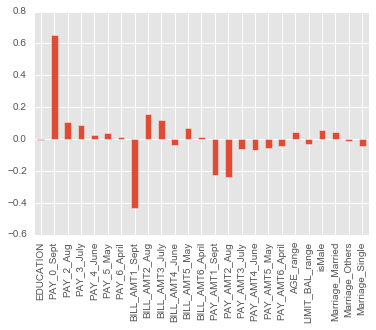

In [15]:
# Graph the coeficients to find the standout features
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(logit_coef_scaled_avg[0],index=cc_data_Xs_names)
weights.plot(kind='bar')
plt.show()

### Logitic Interpretation of Full Model

PAY_0_Sept and BILL_AMT1_Sept are the two strongest indicators of default. Pay_0_Sept and Bill_AMT1_Sept have high weights, >0.4 and <-0.4 respectively, compared to the other coefficients and are significant to the model. Secondarily, PAY_AMT1_Sept and PAY_AMT2_Aug have a similar strength of indicators. PAY_0_Sept indicates how many months late is the payment, so it is logical that as this increases the log odd off default would increase as well. BILL_AMT1 indicates the amount billed, and the weighting suggest counter to logic that bigger bills tended to default less frequently. Due to the high multicollinearity of the BILL_AMT variables, as discovered previously in project 1, this weighting might not be trustable.

### Reduced Logistic Model

In [29]:
cc_data_Xs_logit_reduced = cc_data_processed[[
 'PAY_0_Sept',
 'BILL_AMT1_Sept',
 'PAY_AMT1_Sept',
 'PAY_AMT2_Aug',
]].values

# Column names for labeling
cc_data_Xs_names_lr = cc_data_processed[[
 'PAY_0_Sept',
 'BILL_AMT1_Sept',
 'PAY_AMT1_Sept',
 'PAY_AMT2_Aug',
]].columns

In [46]:
logit_coef_scaled_lr, logit_acc_scaled_lr = full_classify(cc_data_target, cc_data_Xs_logit_reduced, cv_object, 
                                                          logit_clf.best_estimator_, scale=True)

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.sh

SCALED DATA

====Iteration 0  ====
accuracy 0.815166666667
confusion matrix
 [[4522  163]
 [ 946  369]]
Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.97      0.89      4685
          1       0.69      0.28      0.40      1315

avg / total       0.80      0.82      0.78      6000

ROC Score 
 0.622908238006
SCALED DATA

====Iteration 1  ====
accuracy 0.811666666667
confusion matrix
 [[4512  156]
 [ 974  358]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4668
          1       0.70      0.27      0.39      1332

avg / total       0.79      0.81      0.78      6000

ROC Score 
 0.617674872816


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.sh

SCALED DATA

====Iteration 2  ====
accuracy 0.801
confusion matrix
 [[4459  161]
 [1033  347]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.88      4620
          1       0.68      0.25      0.37      1380

avg / total       0.78      0.80      0.76      6000

ROC Score 
 0.608300395257
SCALED DATA

====Iteration 3  ====
accuracy 0.8155
confusion matrix
 [[4554  146]
 [ 961  339]]
Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.97      0.89      4700
          1       0.70      0.26      0.38      1300

avg / total       0.80      0.82      0.78      6000

ROC Score 
 0.614852700491
SCALED DATA

====Iteration 4  ====
accuracy 0.8175
confusion matrix
 [[4548  142]
 [ 953  357]]


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.sh

Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.97      0.89      4690
          1       0.72      0.27      0.39      1310

avg / total       0.80      0.82      0.78      6000

ROC Score 
 0.621120949234
SCALED DATA

====Iteration 5  ====
accuracy 0.808
confusion matrix
 [[4502  163]
 [ 989  346]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4665
          1       0.68      0.26      0.38      1335

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.612117489794


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 6  ====
accuracy 0.804333333333
confusion matrix
 [[4471  142]
 [1032  355]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.88      4613
          1       0.71      0.26      0.38      1387

avg / total       0.79      0.80      0.77      6000

ROC Score 
 0.612582759203
SCALED DATA

====Iteration 7  ====
accuracy 0.816333333333
confusion matrix
 [[4552  145]
 [ 957  346]]
Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.97      0.89      4697
          1       0.70      0.27      0.39      1303

avg / total       0.80      0.82      0.78      6000

ROC Score 
 0.617335145259
SCALED DATA

====Iteration 8  ====
accuracy 0.814


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.sh

confusion matrix
 [[4526  146]
 [ 970  358]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4672
          1       0.71      0.27      0.39      1328

avg / total       0.80      0.81      0.78      6000

ROC Score 
 0.619164156627
SCALED DATA

====Iteration 9  ====
accuracy 0.813833333333
confusion matrix
 [[4533  161]
 [ 956  350]]
Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.97      0.89      4694
          1       0.68      0.27      0.39      1306

avg / total       0.80      0.81      0.78      6000

ROC Score 
 0.616847384592
done. It took 1.5060861110687256 seconds.


The average accuracy score is:  0.811733333333
Coefficients and column names same length: True

PAY_0_Sept has weight of 0.812310007991
BILL_AMT1_Sept has weight of -0.120917975534
PAY_AMT1_Sept has weight of -0.214588963892
PAY_AMT2_Aug has weight of -0.248188273806


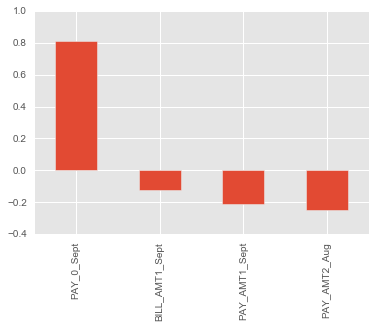

In [47]:
# Below averages the coeficients of the cross validations
logit_coef_scaled_avg_lr = np.array(np.mean( logit_coef_scaled_lr, axis=0 ))
logit_acc_scaled_avg_lr = np.mean(logit_acc_scaled_lr)

print("The average accuracy score is: ", logit_acc_scaled_avg_lr)

# Sanity check to make sure the column name list is the same length as the coefficients
print("Coefficients and column names same length: " + str(len(logit_coef_scaled_avg_lr.T)==len(cc_data_Xs_names_lr)))
print()

# print coefficients with label
zip_vars = zip(logit_coef_scaled_avg_lr.T,cc_data_Xs_names_lr) # combine attributes
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out
    
# Graph the coeficients to find the standout features
weights = pd.Series(logit_coef_scaled_avg_lr[0],index=cc_data_Xs_names_lr)
weights.plot(kind='bar')
plt.show()

# [Enter comparison of full model to reduced model here]

## Support Vector Machine - Using SGDClassifier

In [16]:
# Create New Cross Validation object
cv_object = ShuffleSplit(n=len(cc_data_target), n_iter=10, test_size  = 0.2)

# Initial fixed parmeters
model = SGDClassifier(loss='hinge', n_iter=1, learning_rate='optimal')

# Parameteres to search on:
alpha_values = [.1,1,10,100,1000]
params = {'penalty':('l1','l2'), 
          'alpha':alpha_values, 
          'fit_intercept':(True, False)}

# Run grid search with cv_object
sgd_clf = grid_searcher(model, params, cv_object)

In [17]:
# Print grid serach results
print("The best estimator: ",sgd_clf.best_estimator_)
print("The best accuracy score is: ", sgd_clf.best_score_)
print("The best parameters of model is: ",sgd_clf.best_params_)

The best estimator:  SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=False, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=1, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
The best accuracy score is:  0.771633333333
The best parameters of model is:  {'fit_intercept': False, 'alpha': 0.1, 'penalty': 'l2'}


In [18]:
### Run best model from grid search to get the coefficients from scaled data for interpretation
sgd_coef_scaled = full_classify(cc_data_target, cc_data_Xs, cv_object, sgd_clf.best_estimator_, scale=True)

# model = SVC(C=0.05, kernel='linear', degree=3, gamma='auto')
# full_classify(cc_data_target, cc_data_Xs, cv_object, model, scale=True)

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 0  ====
accuracy 0.584166666667
confusion matrix
 [[2509 2149]
 [ 346  996]]
Classification Report:
              precision    recall  f1-score   support

          0       0.88      0.54      0.67      4658
          1       0.32      0.74      0.44      1342

avg / total       0.75      0.58      0.62      6000

ROC Score 
 0.640409525717


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 1  ====
accuracy 0.585833333333
confusion matrix
 [[2561 2105]
 [ 380  954]]
Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.55      0.67      4666
          1       0.31      0.72      0.43      1334

avg / total       0.75      0.59      0.62      6000

ROC Score 
 0.632003276116


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 2  ====
accuracy 0.6185
confusion matrix
 [[2765 1922]
 [ 367  946]]
Classification Report:
              precision    recall  f1-score   support

          0       0.88      0.59      0.71      4687
          1       0.33      0.72      0.45      1313

avg / total       0.76      0.62      0.65      6000

ROC Score 
 0.655208512924


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 3  ====
accuracy 0.601
confusion matrix
 [[2729 1980]
 [ 414  877]]
Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.58      0.70      4709
          1       0.31      0.68      0.42      1291

avg / total       0.75      0.60      0.64      6000

ROC Score 
 0.629423460095


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 4  ====
accuracy 0.603
confusion matrix
 [[2638 2028]
 [ 354  980]]
Classification Report:
              precision    recall  f1-score   support

          0       0.88      0.57      0.69      4666
          1       0.33      0.73      0.45      1334

avg / total       0.76      0.60      0.64      6000

ROC Score 
 0.649999582292


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 5  ====
accuracy 0.5925
confusion matrix
 [[2598 2050]
 [ 395  957]]
Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.56      0.68      4648
          1       0.32      0.71      0.44      1352

avg / total       0.74      0.59      0.63      6000

ROC Score 
 0.633395161372


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 6  ====
accuracy 0.613166666667
confusion matrix
 [[2764 1900]
 [ 421  915]]
Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.59      0.70      4664
          1       0.33      0.68      0.44      1336

avg / total       0.75      0.61      0.65      6000

ROC Score 
 0.638752298148


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 7  ====
accuracy 0.589333333333
confusion matrix
 [[2598 2086]
 [ 378  938]]
Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.55      0.68      4684
          1       0.31      0.71      0.43      1316

avg / total       0.75      0.59      0.62      6000

ROC Score 
 0.633710049603


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 8  ====
accuracy 0.606833333333
confusion matrix
 [[2724 1950]
 [ 409  917]]
Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.58      0.70      4674
          1       0.32      0.69      0.44      1326

avg / total       0.75      0.61      0.64      6000

ROC Score 
 0.637176002029
SCALED DATA

====Iteration 9  ====
accuracy 0.596166666667
confusion matrix
 [[2628 2032]
 [ 391  949]]
Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.56      0.68      4660
          1       0.32      0.71      0.44      1340

avg / total       0.75      0.60      0.63      6000

ROC Score 
 0.636078726539
done. It took 3.5402023792266846 seconds.


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [19]:
sgd_coef_scaled

[array([[-0.01723268,  0.44626821,  0.16481767,  0.0852592 ,  0.03825015,
          0.03715192,  0.02227449, -0.11232098, -0.06027542, -0.03169943,
         -0.01039102,  0.00607792,  0.01586459, -0.06089009, -0.03541942,
          0.00071777, -0.01990387, -0.04967   , -0.03261937,  0.05382958,
         -0.06814141,  0.01077169,  0.00758833,  0.00212372, -0.00804582]]),
 array([[-0.01024523,  0.46174177,  0.15505329,  0.07427466,  0.02981529,
          0.0228869 ,  0.00536384, -0.10614105, -0.04612056, -0.024747  ,
         -0.00374924, -0.00437182,  0.0018661 , -0.03826555, -0.03602816,
         -0.02003785, -0.02930601, -0.01485808, -0.01747488,  0.02518462,
         -0.05027335,  0.07690745,  0.00473155, -0.02521586,  0.00089175]]),
 array([[-0.04361872,  0.4496379 ,  0.15330011,  0.07233666,  0.03750767,
          0.02052082, -0.00283193, -0.11443238, -0.05451644, -0.02650056,
         -0.00071608,  0.00478081,  0.00643371, -0.06068697, -0.04818383,
         -0.00301828, -0.0398364

In [20]:
# Below averages the coeficients of the cross validations
sgd_coef_scaled_avg = np.array(np.mean( sgd_coef_scaled, axis=0 ))
sgd_coef_scaled_avg

array([[ -2.72790028e-02,   4.43039451e-01,   1.50234848e-01,
          8.12414123e-02,   3.79517316e-02,   2.50030180e-02,
          8.41898327e-03,  -1.08805531e-01,  -5.00805925e-02,
         -2.64602103e-02,  -1.00327217e-02,  -2.19798290e-04,
          4.35845700e-03,  -5.27162266e-02,  -3.54784319e-02,
         -1.34338622e-02,  -2.77443807e-02,  -2.77007447e-02,
         -1.94608021e-02,   4.84848167e-02,  -4.66606434e-02,
          5.58885869e-02,   3.16348050e-02,  -1.37369566e-02,
         -2.85105707e-02]])

In [21]:
# Sanity check to make sure the column name list is the same length as the coefficients
print("Coefficients and column names same length: " + str(len(sgd_coef_scaled_avg.T)==len(cc_data_Xs_names)))
print()

# print coefficients with label
zip_vars = zip(sgd_coef_scaled_avg.T,cc_data_Xs_names) # combine attributes
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

Coefficients and column names same length: True

EDUCATION has weight of -0.0272790028208
PAY_0_Sept has weight of 0.443039451401
PAY_2_Aug has weight of 0.150234847567
PAY_3_July has weight of 0.0812414123399
PAY_4_June has weight of 0.037951731634
PAY_5_May has weight of 0.025003017987
PAY_6_April has weight of 0.00841898326897
BILL_AMT1_Sept has weight of -0.108805530831
BILL_AMT2_Aug has weight of -0.0500805924722
BILL_AMT3_July has weight of -0.0264602102921
BILL_AMT4_June has weight of -0.0100327216746
BILL_AMT5_May has weight of -0.000219798290132
BILL_AMT6_April has weight of 0.00435845699829
PAY_AMT1_Sept has weight of -0.0527162265765
PAY_AMT2_Aug has weight of -0.0354784318595
PAY_AMT3_July has weight of -0.0134338621601
PAY_AMT4_June has weight of -0.0277443807172
PAY_AMT5_May has weight of -0.0277007447273
PAY_AMT6_April has weight of -0.0194608021241
AGE_range has weight of 0.0484848167075
LIMIT_BAL_range has weight of -0.0466606433547
isMale has weight of 0.0558885868631

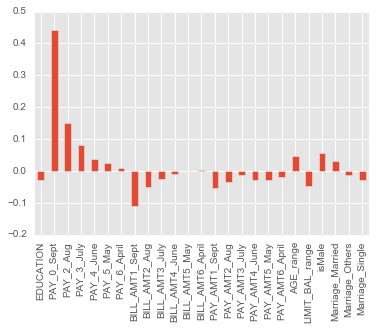

In [22]:
# Graph the coeficients to find the standout features
weights = pd.Series(sgd_coef_scaled_avg[0],index=cc_data_Xs_names)
weights.plot(kind='bar')
plt.show()